# Setup model and install packages
**Warning:**  This package is a proof of concept.  While the code will remain working with proper use of a [Julia manifest](https://pkgdocs.julialang.org/v1/), you should not rely on this for research unless you are prepared to modify the source and help maintain it.

Remove comment below to install the exact version of packages listed in the manifest.

In [2]:
# ] instantiate 

The core package is `DifferentiableStateSpaceModels.jl` where `DifferenceEquations.jl` provides compatible functionality for simulating and calculating likelihoods

In [111]:
using DifferentiableStateSpaceModels, DifferenceEquations, LinearAlgebra, Zygote, Distributions, Plots, DiffEqBase, Symbolics, BenchmarkTools

# Model Class
The model follows [Schmitt-Grohe and Uribe (2004)](http://www.columbia.edu/~mu2166/2nd_order/2nd_order.pdf) timing convention.  The system takes a nonlinear expectational difference equation including all first-order conditions for decisions and the system evolution equations,

$$
\mathbb{E}_{t}\mathcal{H}\left(\hat{y}',\hat{y},\hat{x}',\hat{x};p\right)=0
$$
where $\hat{y}$ are the control variables, $\hat{x}$ are the states, and $p$ is a vector of deep parameters of interest.  Expectations are taken over forward-looking variables and an underlying random process $\epsilon'$.

In addition, we consider an observation equation - which might be noisy for
$$
\hat{z} = Q \cdot \begin{bmatrix}\hat{y} &\hat{x}\end{bmatrix}^{\top} + \nu
$$
where $\nu$ may or may not be normally distributed but $\mathbb{E}(\nu) = 0$ and $\mathbb{V}(\nu) = \Omega(p) \Omega(p)^{\top}$.

Assume that there is a non-stochastic steady state of this problem as $y_{ss}, x_{ss}$.

## Perturbation Solution
Define the deviation from the non-stochastic steady state as$x \equiv \hat{x} - x_{ss}$, and $y \equiv \hat{y} - y_{ss}$.

The solution finds the first or second order perturbation around that non-stochastic steady state, and yields a
$$
x' = h(x; p) + \eta \, \Gamma(p)\, \epsilon'
$$
where $\eta$ describes how shocks affect the law of motion and $\mathbb{E}(\epsilon') = 0$.  Frequently this would be organized such that $\mathbb{V}(\epsilon)= I$, but that is not required.  In addition, it could instead be interpreted as for $x' = h(x; p) + \eta \, \epsilon'$ with $\mathbb{V}(\epsilon') = \Gamma(p) \Gamma(p)^{\top}$.

and with the policy equation,
$$
y = g(x; p)
$$
and finally, substitution in for the observation equation
$$
z = h(x; p) + \nu
$$
where
$$
h(x; p) \equiv Q \begin{bmatrix} g(x;p) \\ x\end{bmatrix}
$$

## First Order Solutions
For example, in the case of the 1st order model the solution finds,
$$
x' = A(p)\, x + B(p) \epsilon'
$$
and
$$
y = g_x(p) \, x
$$
and 
$$
z = C(p)\, x + \nu
$$
where $C(p)\equiv Q \begin{bmatrix} g_x(p) \\ I\end{bmatrix}$, $B(p) \equiv \eta \Gamma(p)$, and $\mathbb{V}(v) = D(\nu) D(p)^{\top}$.  Normality of $\nu$ or $\epsilon'$ is not required in general.

This is a linear state-space model and if the priors and shocks are gaussian, a marginal likelihood can be evaluated with classic methods such as a Kalman Filter.  The output of the perturbation can be used manually, or in conjunction with [DifferenceEquations.jl](https://github.com/SciML/DifferenceEquations.jl).

## Second Order Solutions
This package also solves for second order perturbations, with all of the same features and with easy   The canonical form of the second order solution implements state-space pruning as in [Andreasen, Fernandez-Villaverde, and Rubio-Ramirez (2017)](https://www.sas.upenn.edu/~jesusfv/Pruning.pdf).  Given the same formulation of the problem, the model finds the canonical form,
$$
x' = A_0(p) + A_1(p)\, x + x^{\top} A_2(p)\, x + B(p) \epsilon'
$$
and
$$
y = g_{\sigma\sigma} + g_x \, x + x^{\top}\,g_{xx}\,x
$$
and 
$$
z = C_0(p) + C_1(p)\, x + x^{\top} C_2(p)\, x + \nu
$$
where $B(p) \equiv \eta \Gamma(p)$, $\mathbb{V}(v) = D(\nu) D(p)^{\top}$, and the $C_0,C_1,C_2,A_0, A_1, A_2$ all reflect the state space pruning.

## Gradients
All of the above use standard solution methods.  The primary contribution of this package is that all of these model elements are **differentiable**. Hence, these gradeients can be composed for use in applications such as optimization, gradient-based estimation methods, and with  [DifferenceEquations.jl](https://github.com/SciML/DifferenceEquations.jl)  which provides differentiable simulations and likelihoods for state-space models.  That is, if we think of a perturbation solver mapping $p$ to solutions (e.g. in first order $\mathbf{P}(p) \to (A, B, C, D)$, then we can find the gradients $\partial_p \mathbf{P}(p), \partial_p A(p)$ etc.  Or, when these gradients are available for use with reverse-mode auto-differentiation, it can take "wobbles" in $A, B, C, D$ and go back to the "wiggles" of the underlying $p$ through $\mathbf{P}$.  See [ChainRules.jl](https://juliadiff.org/ChainRulesCore.jl/stable/maths/propagators.html) for more details on AD.  


## Model Primitives
Models are defined using a Dynare-style DSL using [Symbolics.jl](https://github.com/JuliaSymbolics/Symbolics.jl).  The list of primitives are:
1. The list of variables for the controls $y$, state $x$, and deep parameters $p$.
2. The set of equations $H$ as a function of $p, y(t), y(t+1), x(t),$ and $x(t+1)$.  No $t-1$ timing are allowed.
3. The loading of shocks $\eta$ as a fixed matrix of constants
4. The shock covariance cholesky $\Gamma$ as a function of parameters $p$
5. The observation equation $Q$ as a fixed matrix.
6. The cholesky of the observation errors, $\Omega$ as a function of parameters $p$.  At this point only a diagonal matrix is support.
7. Either the steady state equations for all of $y$ and $x$ in closed form as a function of $p$, or initial conditions for the nonlinear solution to solve for the steady state as functions of $p$

# RBC Example
This example implements the model primitives to build a simple version of the RBC model with two observables.

In [53]:
∞ = Inf
@variables α, β, ρ, δ, σ, Ω_1
@variables t::Integer, k(..), z(..), c(..), q(..)

x = [k, z] # states
y = [c, q] # controls
p = [α, β, ρ, δ, σ, Ω_1] # parameters

H = [1 / c(t) - (β / c(t + 1)) * (α * exp(z(t + 1)) * k(t + 1)^(α - 1) + (1 - δ)),
     c(t) + k(t + 1) - (1 - δ) * k(t) - q(t),
     q(t) - exp(z(t)) * k(t)^α,
     z(t + 1) - ρ * z(t)]  # system of model equations

# analytic solutions for the steady state
steady_states = [k(∞) ~ (((1 / β) - 1 + δ) / α)^(1 / (α - 1)),
                 z(∞) ~ 0,
                 c(∞) ~ (((1 / β) - 1 + δ) / α)^(α / (α - 1)) -
                        δ * (((1 / β) - 1 + δ) / α)^(1 / (α - 1)),
                 q(∞) ~ (((1 / β) - 1 + δ) / α)^(α / (α - 1))]


Γ = [σ;;] # matrix for the 1 shock.  The [;;] notation just makes it a matrix rather than vector in julia
η = [0; -1;;] # η is n_x * n_ϵ matrix.  The [;;]

# observation matrix.  order is "y" then "x" variables, so [c,q,k,z] in this example
Q = [1.0 0  0   0; # select c as first "z" observable
     0   0  1.0 0] # select k

# diagonal cholesky of covariance matrix for observation noise (so these are standard deviations).  Non-diagonal observation noise not currently supported
Ω = [Ω_1, Ω_1]

# Generates the files and includes if required.  If the model is already created, then just loads
overwrite_model_cache  = true
model_rbc = @make_and_include_perturbation_model("rbc_notebook_example", H, (; t, y, x, p, steady_states, Γ, Ω, η, Q, overwrite_model_cache)) # Convenience macro.  Saves as ".function_cache/rbc_notebook_example.jl"

# After generation could just include the files directly, or add the following to prevent overwriting the models
# isdefined(Main, :rbc_notebook_example) || include(joinpath(pkgdir(DifferentiableStateSpaceModels),
#                                              "test/generated_models/rbc_notebook_example.jl"))
# Alternatively, this is also the same example as a prebuilt example
# model_rbc = @include_example_module(DifferentiableStateSpaceModels.Examples.rbc_observables)

Perturbation Model: n_y = 2, n_x = 2, n_p = 6, n_ϵ = 1, n_z = 2
 y = [:c, :q] 
 x = [:k, :z] 
 p = [:α, :β, :ρ, :δ, :σ, :Ω_1]

As commented above, the convenience macro will take this model, generate files, and include them.  It called the function [`make_perturbation_model`](https://github.com/HighDimensionalEconLab/DifferentiableStateSpaceModels.jl/blob/main/src/make_perturbation_model.jl#L6-L13) with the associated options in that file.  Once generated these can be included as normal `.jl` files.  At this point, there are no runtime generated functions though that functionality could be added later.  The following queries some of the properties of the loaded model.

In [6]:
model_H_latex(model_rbc)

L"$\begin{equation}
\left[
\begin{array}{c}
\frac{ - \beta \left( 1 - \delta + \left( k\left( 1 + t \right) \right)^{-1 + \alpha} \alpha e^{z\left( 1 + t \right)} \right)}{c\left( 1 + t \right)} + \frac{1}{c\left( t \right)} \\
 - q\left( t \right) - \left( 1 - \delta \right) k\left( t \right) + c\left( t \right) + k\left( 1 + t \right) \\
 - \left( k\left( t \right) \right)^{\alpha} e^{z\left( t \right)} + q\left( t \right) \\
 - \rho z\left( t \right) + z\left( 1 + t \right) \\
\end{array}
\right]
\end{equation}
$"

In [7]:
model_steady_states_latex(model_rbc)  # this is the closed form steady state, could instead pass in the state_states_iv to give approximation initial conditions for optimizer instead

L"$\begin{align}
k\left( \infty \right) =& \left( \frac{-1 + \delta + \frac{1}{\beta}}{\alpha} \right)^{\frac{1}{-1 + \alpha}} \\
z\left( \infty \right) =& 0 \\
c\left( \infty \right) =& \left( \frac{-1 + \delta + \frac{1}{\beta}}{\alpha} \right)^{\frac{\alpha}{-1 + \alpha}} - \left( \frac{-1 + \delta + \frac{1}{\beta}}{\alpha} \right)^{\frac{1}{-1 + \alpha}} \delta \\
q\left( \infty \right) =& \left( \frac{-1 + \delta + \frac{1}{\beta}}{\alpha} \right)^{\frac{\alpha}{-1 + \alpha}}
\end{align}
$"

In [8]:
@show model_rbc.n_x, model_rbc.n_y, model_rbc.n_z, model_rbc.n_ϵ

(model_rbc.n_x, model_rbc.n_y, model_rbc.n_z, model_rbc.n_ϵ) = (2, 2, 2, 1)


(2, 2, 2, 1)

## Solving Perturbations

Given a model definition, you can solve the expectational difference equation for a given set of parameters.  All of the `p` defined above must be in either the `p_d` or the `p_f` arguments below.

The distinction between these is that the `p_d` parameters will be available for differentiation where the `p_f` will be fixed.  That is, for any parameters in the `p_d` the model will support calculation of gradients of   the perturbation solution.  The only downside with having extra values in `p_d` vs. `p_f` is extra computation.  Otherwise, pass in `nothing` for `p_f` if you are differentiating all of the parameters

In [37]:
p_f = (ρ = 0.2, δ = 0.02, σ = 0.01, Ω_1 = 0.01) # Fixed parameters
p_d = (α = 0.5, β = 0.95) # Pseudo-true values
sol = generate_perturbation(model_rbc, p_d, p_f) # Solution to the first-order RBC
sol_2 = generate_perturbation(model_rbc, p_d, p_f, Val(2)); # Solution to the second-order RBC
@show sol.retcode, sol_2.retcode;

(sol.retcode, sol_2.retcode) = (:Success, :Success)


The perturbation solution (in the canonical form described in the top section) can be queried from the resulting solution.  A few examples for the first order solution are below,

In [127]:
@show sol.y, sol.x  # steady state ŷ and x̂  These are the values such that y ≡ ŷ - sol.y and x ≡ x̂ - sol.x
@show sol.g_x # the policy
@show sol.A, sol.B # the evolution equation of the state, so that x' = A x + B ϵ
@show sol.C, sol.D; # the evolution equation of the state, so that z = C x + ν  with variance of ν as D D'.
@show sol.x_ergodic_var; # covariance matrix of the ergodic distribution of x, which is mean zero since x ≡ x̂ - x_ss

(sol.y, sol.x) = ([5.936252888048732, 6.884057971014497], [47.39025414828823, 0.0])
sol.g_x = [0.09579643002416627 0.6746869652586192; 0.07263157894736873 6.884057971014506]
(sol.A, sol.B) = ([0.9568351489232028 6.2093710057558855; 1.5076865909646354e-18 0.20000000000000004], [0.0; -0.01;;])
(sol.C, sol.D) = ([0.09579643002416627 0.6746869652586192; 1.0 0.0], [0.0001, 0.0001])
sol.x_ergodic_var = [0.07005411173180152 0.00015997603451513398; 0.00015997603451513398 0.00010416666666666667]


In addition, you can query some metadata about the solution to aid in debugging and generic programming

In [52]:
@show sol.Q, sol.η, sol.Γ; # various matrices for loading of shocks and observations
@show sol.n_y, sol.n_x, sol.n_ϵ, sol.n_z, sol.n_p # sizes of model
@show sol.x_symbols, sol.y_symbols, sol.p_symbols; # the order of symbols for the x vector

(sol.Q, sol.η, sol.Γ) = ([1.0 0.0 0.0 0.0; 0.0 0.0 1.0 0.0], [0; -1;;], [0.01;;])
(sol.n_y, sol.n_x, sol.n_ϵ, sol.n_z, sol.n_p) = (2, 2, 1, 2, 6)
(sol.x_symbols, sol.y_symbols, sol.p_symbols) = ([:k, :z], [:c, :q], [:α, :β, :ρ, :δ, :σ, :Ω_1])


## Functions of Perturbation Solutions (and their Derivatives)
The core feature of this library is to enable gradients of the perturbagion solutions with respect to parameters (i.e., anythign in the `p_d` vector).  To show this, we will construct a function which uses the resulting law of motion and finds the gradient of the results with respect to this value.

In [123]:
function IRF(p_d, ϵ_0; m, p_f, steps)
    sol = generate_perturbation(m, p_d, p_f) # First-order perturbation by default, pass Val(2) as additional argument to do 2nd order.
    x = sol.B * ϵ_0 # start after applying impulse with the model's shock η and Γ(p)
    for _ in 1:steps
        # A note: you cannot use mutating expressions here with most AD code.  i.e. x .= sol.A * x  wouldn't work
        # For more elaborate simuluations, you would want to use DifferenceEquations.jl in practice
        x = sol.A * x # iterate forward using first-order observation equation        
    end    
    return [0, 1]' * sol.C * x # choose the second observable using the model's C observation equation since first-order
end

m = model_rbc  # ensure notebook executed above
p_f = (ρ=0.2, δ=0.02, σ=0.01, Ω_1=0.01) # not differentiated 
p_d = (α=0.5, β=0.95) # different parameters
steps = 10 # steps ahead to forecast
ϵ_0 = [1.0] # shock size
IRF(p_d, ϵ_0; m, p_f, steps) # Function works on its own, calculating perturbation

-0.052773688889493325

However, the real benefit is that this function can itself be differentiated, to find gradients with respect to the deep parameters `p_d` and the shock `ϵ_0`

In [99]:
# Using the Zygote auto-differentiation library already loaded above
p_d = (α=0.5, β=0.95) # different parameters
ϵ_0 = [1.0] # shock size
IRF_grad = gradient((p_d, ϵ_0) -> IRF(p_d, ϵ_0; m, p_f, steps), p_d, ϵ_0) # "closes" over the m, p_f, and steps to create a new function, and differentiates it with respect to other arguments

((α = -0.5810083808068426, β = -1.1823123518725853), [-0.05277368888949331])

In [104]:
println("∇_α IRF(p_d, ϵ0) = $(IRF_grad[1].α), ∇_β IRF(p_d, ϵ0) = $(IRF_grad[1].β), ∇_ϵ0 IRF(p_d, ϵ0) = $(IRF_grad[2])")

∇_α IRF(p_d, ϵ0) = -0.5810083808068426, ∇_β IRF(p_d, ϵ0) = -1.1823123518725853, ∇_ϵ0 IRF(p_d, ϵ0) = [-0.05277368888949331]


## Using Solution Cache

The calculation of the gradients of the perturbation solution is slow relative to the perturbation itself, and both can allocate a significant amount of memory.  If you intend to keep calculating a perturbation a large number of times (e.g., during estimation), then you may want to preallocate this memory and reuse it by passing in a cache.

In [124]:
function IRF_cache(p_d, ϵ_0; m, p_f, steps, cache)
    sol = generate_perturbation(m, p_d, p_f; cache)  # only difference is passing in a pre-allocated cache to the perturbation solver
    x = sol.B * ϵ_0
    for _ in 1:steps
        x = sol.A * x
    end    
    return [0, 1]' * sol.C * x
end

# To call it
m = model_rbc  # ensure notebook executed above
p_d = (α=0.5, β=0.95)  # Differentiated parameters
p_f = (ρ=0.2, δ=0.02, σ=0.01, Ω_1=0.01)
steps = 10 # steps ahead to forecast
ϵ_0 = [1.0] # shock size
cache = SolverCache(m, Val(1), p_d)   # the p_d passed into the cache just reuses the symbols, and the values in p_d are unused
@show IRF_cache(p_d, ϵ_0; m, p_f, steps, cache)
gradient((p_d, ϵ_0) -> IRF_cache(p_d, ϵ_0; m, p_f, steps, cache), p_d, ϵ_0)  # as before, do not try to differentiate with respect to the cache values itself.

IRF_cache(p_d, ϵ_0; m, p_f, steps, cache) = -0.052773688889493325


((α = -0.5810083808068426, β = -1.1823123518725853), [-0.05277368888949331])

In [125]:
# However, in a problem this small you will not see much of a difference in performance
@btime IRF($p_d, $ϵ_0; m = $m, p_f = $p_f, steps = $steps)
@btime IRF_cache($p_d, $ϵ_0; m = $m, p_f = $p_f, steps = $steps, cache = $cache)

  88.100 μs (214 allocations: 86.59 KiB)
  80.700 μs (125 allocations: 75.72 KiB)


-0.052773688889493325

## Simulating with DifferenceEquations.jl
The manual iteration of the state-space model from the perturbation solution is possible, but can be verbose and difficult to achieve efficiency for gradients.  One benefit of this package is that it creates state-space models in a form consistent with [DifferenceEquations.jl](https://github.com/SciML/DifferenceEquations.jl) which can be easily simulated, visualized, and estimated.

To do this, we will calculate a perturbation solution then simulate it for various `x_0` drawn from the ergodic solution.

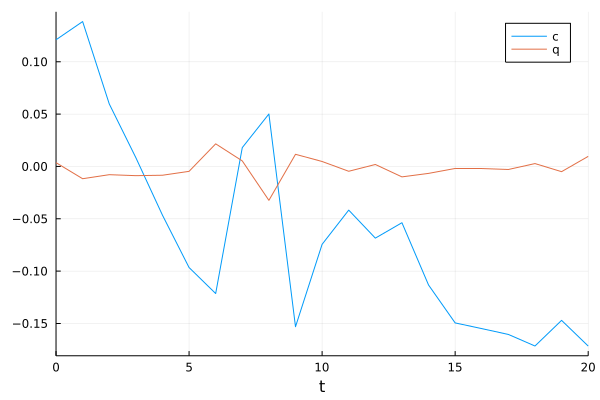

In [132]:
p_f = (ρ = 0.2, δ = 0.02, σ = 0.01, Ω_1 = 0.01) # Fixed parameters
p_d = (α = 0.5, β = 0.95) # Pseudo-true values
m = model_rbc  # ensure notebook executed above
sol = generate_perturbation(m, p_d, p_f) # Solution to the first-order RBC

# Simulate T observations from a random initial condition
T = 20

# draw from ergodic distribution for the initial condition
x_iv = MvNormal(sol.x_ergodic_var)
problem = LinearStateSpaceProblem(sol, x_iv, (0, T))
plot(solve(problem, DirectIteration()))

The `LinearStateSpaceProblem` type is automatically constructed from the underlying perturbation.  However, we can override any of these options, or pass in our own noise rather than simulate it for a particular experiment

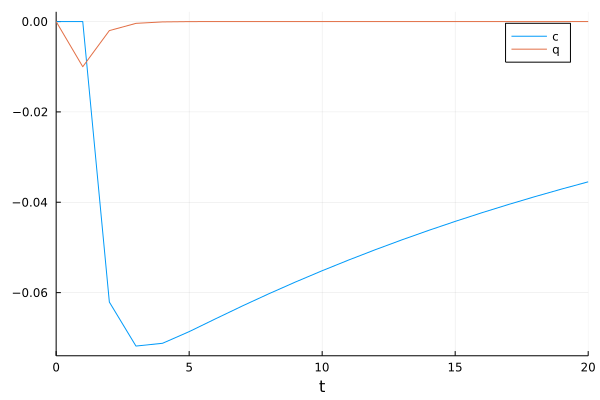

In [149]:
noise = Matrix([1.0; zeros(T-1)]') # the ϵ shocks are "noise" in DifferenceEquations for SciML compatibility
x_iv = [0.0, 0.0]  # can pass in a single value rather than a distribution 
problem = LinearStateSpaceProblem(sol, x_iv, (0, T); noise)
plot(solve(problem, DirectIteration()))

To demonstrate the composition of gradients between DifferenceEquations and DifferentiableStateSpaceModels lets adapt this function to simulates an impulse with fixed noise and looks at the final observable

In [182]:
function last_observable(p_d, noise, x_iv; m, p_f, T)
    sol = generate_perturbation(m, p_d, p_f)
    problem = LinearStateSpaceProblem(sol, x_iv, (0, T);noise, observables_noise = nothing)  # removing observation noise
    return solve(problem, DirectIteration()).z[end][2]  # return 2nd argument of last observable
end
T = 100
noise = Matrix([1.0; zeros(T-1)]') # the ϵ shocks are "noise" in DifferenceEquations for SciML compatibility
x_iv = [0.0, 0.0]  # can pass in a single value rather than a distribution
p_f = (ρ = 0.2, δ = 0.02, σ = 0.01, Ω_1 = 0.01) # Fixed parameters
p_d = (α = 0.5, β = 0.95) # Pseudo-true values
m = model_rbc  # ensure notebook executed above
last_observable(p_d, noise, x_iv; m, p_f, T)

-0.001039731618424578

And, as before, we can calculate gradients with respect to the underlying `p_d` parameters, but also with respect to the noise which will demonstrate a key benefit of these methods, as they can let us do a joint likelihood of the latent variables in cases where they cannot be easily marginalized out (e.g., non-gaussian or nonlinear).  Note that the dimensionality of this gradient is over 100.

In [174]:
gradient((p_d, noise, x_iv) -> last_observable(p_d, noise, x_iv; m, p_f, T), p_d, noise, x_iv)

LoadError: AssertionError: typeof(observables_noise) <: ZeroMeanDiagNormal

## Sneak Peak at SciML Compatable Functionality
Finally, there are a variety of features of SciML which are supported.  For example, parallel simulations of ensembles and associated summary statistics

In [175]:
# Simulate multiple trajectories with T observations
trajectories = 40
x_iv = MvNormal(sol.x_ergodic_var)
problem = LinearStateSpaceProblem(sol, x_iv, (0, T))

# Solve multiple trajectories and plot an ensemble
ensemble_results = solve(EnsembleProblem(problem), DirectIteration(), EnsembleThreads();
                 trajectories)
summ = EnsembleSummary(ensemble_results)  # see SciML documentation.  Calculates median and other quantles automatically.
summ.med # median values for the "x" simulated ensembles

t: 0:100
u: 101-element Vector{Vector{Float64}}:
 [-0.05598697731119057, -0.0008909662332453935]
 [-0.014097245571894408, 0.002145537921135401]
 [0.02973117439264411, 0.0019672757214644412]
 [0.026563666932748312, 0.0018250797543322905]
 [0.010988470948292776, 0.0019978954488062296]
 [0.023576848128376127, 0.0011711400684336541]
 [0.03260386995676576, -0.0016202749648036334]
 [0.04220036617781859, -0.0005124373978992264]
 [0.017437999655830348, 0.0010298430393164961]
 [0.0022965425503533275, 7.580948505216866e-5]
 [-0.024053060315015508, -0.005020253695360915]
 [-0.03249678682513134, 0.001773490957079701]
 [-0.013417556690023159, -0.001475703757166229]
 ⋮
 [0.04502060913846951, -0.0017480148402180284]
 [0.017795737795281433, 0.00029091063240098755]
 [-0.0023065963236944204, 0.0006197026935802967]
 [0.023165621396375555, 0.001765153885564806]
 [0.003526311520198277, 0.0026905777750219945]
 [0.03841872954925316, 0.0019209316734803605]
 [0.063329051872667, 0.0006262868145453487]
 [-0.0091

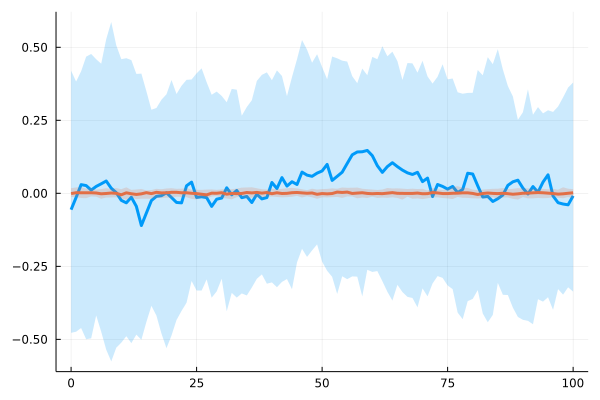

In [176]:
plot(summ, fillalpha= 0.2) # plots by default show the median and quantiles of both variables.  Modifying transparency as an example

## Calculate sequence of observables
We can use the underlying state-space model to easily simulate states and observables

In [177]:
# Simulate T observations
T = 20

p_f = (ρ = 0.2, δ = 0.02, σ = 0.01, Ω_1 = 0.01) # Fixed parameters
p_d = (α = 0.5, β = 0.95) # Pseudo-true values
sol = generate_perturbation(model_rbc, p_d, p_f) # Solution to the first-order RBC

x_iv = MvNormal(sol.x_ergodic_var) # draw initial conditions from the ergodic distribution
problem = LinearStateSpaceProblem(sol, x_iv, (0, T))
sim = solve(problem, DirectIteration())
ϵ = sim.W # store the underlying noise in the simulation

# Collapse to simulated observables as a matrix  - as required by current DifferenceEquations.jl likelihood
# see https://github.com/SciML/DifferenceEquations.jl/issues/55 for direct support of this datastructure
z_rbc = hcat(sim.z...) 

2×21 Matrix{Float64}:
 0.022674  0.0265414  0.0105867  …  0.0214261  0.0055876  0.00416553
 0.157358  0.233235   0.206499      0.135604   0.131875   0.110685

# Bayesian estimation with Turing 

In [178]:
using Turing
using Turing: @addlogprob!
Turing.setadbackend(:zygote);

## First-order, marginal likelihood approach

In [181]:
# Turing model definition
@model function rbc_kalman(z, m, p_f, cache, settings)
    α ~ Uniform(0.2, 0.8)
    β ~ Uniform(0.5, 0.99)
    p_d = (; α, β)
    T = size(z, 2)
    sol = generate_perturbation(m, p_d, p_f, Val(1); cache, settings) # first-order perturbation
    if !(sol.retcode == :Success)
        @addlogprob! -Inf
        return
    end
    problem = LinearStateSpaceProblem(sol, zeros(2), (0, T), observables = z)
    @addlogprob! solve(problem, KalmanFilter()).logpdf
end
cache = SolverCache(model_rbc, Val(1),  [:α, :β])
settings = PerturbationSolverSettings(; print_level = 0)
p_f = (ρ = 0.2, δ = 0.02, σ = 0.01, Ω_1 = 0.01) # Fixed parameters
z = z_rbc # simulated in previous steps
turing_model = rbc_kalman(z, model_rbc, p_f, cache, settings) # passing observables from before 

n_samples = 1000
n_adapts = 250
δ = 0.65
alg = NUTS(n_adapts,δ)
println("Sampling.  Ignore that 'rejected due to numericfal errors' warnings")  # At this point, Turing can't turn off those warnings
chain_1_marginal = sample(turing_model, alg, n_samples; progress = true)

Sampling.  Ignore that 'rejected due to numericfal errors' warnings


┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference C:\Users\jesse\.julia\packages\Turing\S4Y4B\src\inference\hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\jesse\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
Sampling:   2%|█                                        |  ETA: 0:00:11┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, false, true)
└ @ AdvancedHMC C:\Users\jesse\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
Sampling:   6%|███                                      |  ETA: 0:00:12┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\jesse\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
Sampling:  10%|█████                                    

Chains MCMC chain (1000×14×1 Array{Float64, 3}):

Iterations        = 251:1:1250
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 20.41 seconds
Compute duration  = 20.41 seconds
parameters        = α, β
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

           α    0.4143    0.0328     0.0010    0.0020   230.6722    0.9990     ⋯
           β    0.9577    0.0073     0.0002    0.0005   172.6457    1.0041     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

         

## First-order, joint likelihood approach

In [180]:
# Turing model definition
@model function rbc_1_joint(z, m, p_f, cache, settings)
    α ~ Uniform(0.2, 0.8)
    β ~ Uniform(0.5, 0.99)
    p_d = (; α, β)
    T = size(z, 2)
    ϵ_draw ~ MvNormal(m.n_ϵ * T, 1.0)
    ϵ = reshape(ϵ_draw, m.n_ϵ, T)
    sol = generate_perturbation(m, p_d, p_f, Val(1); cache, settings)
    if !(sol.retcode == :Success)
        @addlogprob! -Inf
        return
    end
    problem = LinearStateSpaceProblem(sol, zeros(2), (0, T), observables = z, noise=ϵ)
    @addlogprob! solve(problem, DirectIteration()).logpdf
end
cache = SolverCache(model_rbc, Val(1),  [:α, :β])
settings = PerturbationSolverSettings(; print_level = 0)
p_f = (ρ = 0.2, δ = 0.02, σ = 0.01, Ω_1 = 0.01) # Fixed parameters
z = z_rbc # simulated in previous steps
turing_model = rbc_1_joint(z, model_rbc, p_f, cache, settings) # passing observables from before 

n_samples = 1000
n_adapts = 250
δ = 0.65
alg = NUTS(n_adapts,δ)
chain_1_joint = sample(turing_model, alg, n_samples; progress = true)

┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference C:\Users\jesse\.julia\packages\Turing\S4Y4B\src\inference\hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\jesse\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
Sampling:   1%|█                                        |  ETA: 0:00:30┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\jesse\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
Sampling:  10%|█████                                    |  ETA: 0:06:04┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\jesse\.julia\packages\AdvancedHMC\51xgc\src\hamiltonian.jl:47
Sampling: 100%|████████████████████████████████████████

Chains MCMC chain (1000×35×1 Array{Float64, 3}):

Iterations        = 251:1:1250
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 14709.26 seconds
Compute duration  = 14709.26 seconds
parameters        = α, β, ϵ_draw[1], ϵ_draw[2], ϵ_draw[3], ϵ_draw[4], ϵ_draw[5], ϵ_draw[6], ϵ_draw[7], ϵ_draw[8], ϵ_draw[9], ϵ_draw[10], ϵ_draw[11], ϵ_draw[12], ϵ_draw[13], ϵ_draw[14], ϵ_draw[15], ϵ_draw[16], ϵ_draw[17], ϵ_draw[18], ϵ_draw[19], ϵ_draw[20], ϵ_draw[21]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           α    0.4971    0.0246     0.0008    0.0013    319.1558    0.9990    ⋯
           β    0.9511    0.0082     0.0003    0.0003    596.0

## Second-order, joint likelihood approach

In [33]:
# Turing model definition
@model function rbc_2_joint(z, m, p_f, cache, settings)
    α ~ Uniform(0.2, 0.8)
    β ~ Uniform(0.5, 0.99)
    p_d = (; α, β)
    T = size(z, 2)
    ϵ_draw ~ MvNormal(m.n_ϵ * T, 1.0) # add noise to the estimation
    ϵ = reshape(ϵ_draw, m.n_ϵ, T)
    sol = generate_perturbation(m, p_d, p_f, Val(2); cache, settings)
    if !(sol.retcode == :Success)
        @addlogprob! -Inf
        return
    end
    problem = QuadraticStateSpaceProblem(sol, zeros(2), (0, T), observables = z, noise=ϵ)
    @addlogprob! solve(problem, DirectIteration()).logpdf
end
cache = SolverCache(model_rbc, Val(2),  [:α, :β])
settings = PerturbationSolverSettings(; print_level = 0)
z = z_rbc # simulated in previous steps
p_f = (ρ = 0.2, δ = 0.02, σ = 0.01, Ω_1 = 0.01) # Fixed parameters
turing_model = rbc_2_joint(z, model_rbc, p_f, cache, settings) # passing observables from before 

n_samples = 1000
n_adapts = 250
δ = 0.65
alg = NUTS(n_adapts,δ)
chain_2_joint = sample(turing_model, alg, n_samples; progress = true)

┌ Info: Found initial step size
│   ϵ = 0.024998474121093753
└ @ Turing.Inference C:\Users\jesse\.julia\packages\Turing\S4Y4B\src\inference\hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:07:15


Chains MCMC chain (1000×35×1 Array{Float64, 3}):

Iterations        = 101:1:1100
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 462.14 seconds
Compute duration  = 462.14 seconds
parameters        = α, β, ϵ_draw[1], ϵ_draw[2], ϵ_draw[3], ϵ_draw[4], ϵ_draw[5], ϵ_draw[6], ϵ_draw[7], ϵ_draw[8], ϵ_draw[9], ϵ_draw[10], ϵ_draw[11], ϵ_draw[12], ϵ_draw[13], ϵ_draw[14], ϵ_draw[15], ϵ_draw[16], ϵ_draw[17], ϵ_draw[18], ϵ_draw[19], ϵ_draw[20], ϵ_draw[21]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           α    0.4796    0.0218     0.0007    0.0013    220.0016    1.0116    ⋯
           β    0.9540    0.0057     0.0002    0.0002   1064.5634 

## Plotting the estimated latent states

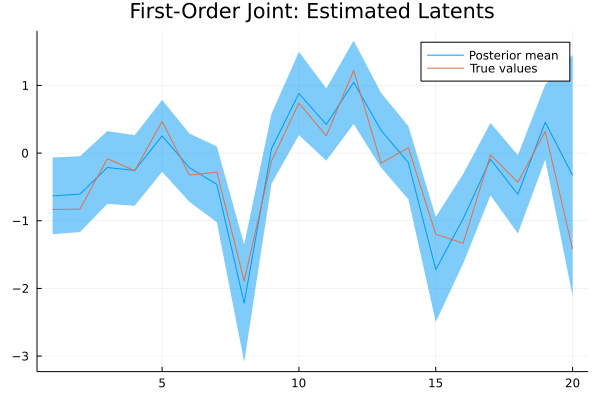

In [34]:
symbol_to_int(s) = parse(Int, string(s)[9:end-1])
ϵ_chain = sort(chain_1_joint[:, [Symbol("ϵ_draw[$a]") for a in 1:21], 1], lt = (x,y) -> symbol_to_int(x) < symbol_to_int(y))
tmp = describe(ϵ_chain)
ϵ_mean = tmp[1][:, 2]
ϵ_std = tmp[1][:, 3]
plot(ϵ_mean[2:end], ribbon=2 * ϵ_std[2:end], label="Posterior mean", title = "First-Order Joint: Estimated Latents")
plot!(ϵ', label="True values")

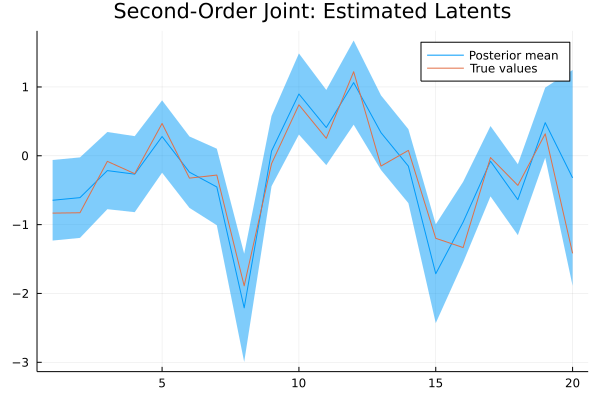

In [35]:
ϵ_chain = sort(chain_2_joint[:, [Symbol("ϵ_draw[$a]") for a in 1:21], 1], lt = (x,y) -> symbol_to_int(x) < symbol_to_int(y))
tmp = describe(ϵ_chain)
ϵ_mean = tmp[1][:, 2]
ϵ_std = tmp[1][:, 3]
plot(ϵ_mean[2:end], ribbon=2 * ϵ_std[2:end], label="Posterior mean", title = "Second-Order Joint: Estimated Latents")
plot!(ϵ', label="True values")